In [1]:
import matplotlib.pyplot as plt
import numpy as np

import bemcs

%config InlineBackend.figure_format = "retina"

# Model parameters

In [2]:
# Reference triangle geometry
triangle = np.array([[-0.5, 0.5], [2.0, 1.0], [0.5, 2.0]])  # Works

# Observation coordinates
x_obs, y_obs = np.meshgrid(np.linspace(-10, 10, 30), np.linspace(-10, 10, 30))
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Forces
fx = 1.0
fy = 0.0

# Elastic parameters
mu = 1.0
nu = 0.25

# Near-field numerical integration using `scipy.integrate.dblquad`

In [3]:
ux_near, uy_near, sxx_near, syy_near, sxy_near = (
    bemcs.displacements_stresses_triangle_force_planestrain_nearfield(
        triangle, x_obs, y_obs, fx, fy, mu, nu
    )
)

# Far-field numerical integration using `quadpy`

In [4]:
ux_far, uy_far, sxx_far, syy_far, sxy_far = (
    bemcs.displacements_stresses_triangle_force_planestrain_farfield(
        triangle, x_obs, y_obs, fx, fy, mu, nu
    )
)

# Near-field for near-field.  Far-field for far-field

In [5]:
ux, uy, sxx, syy, sxy = bemcs.displacements_stresses_triangle_force_planestrain(
    triangle, x_obs, y_obs, fx, fy, mu, nu
)

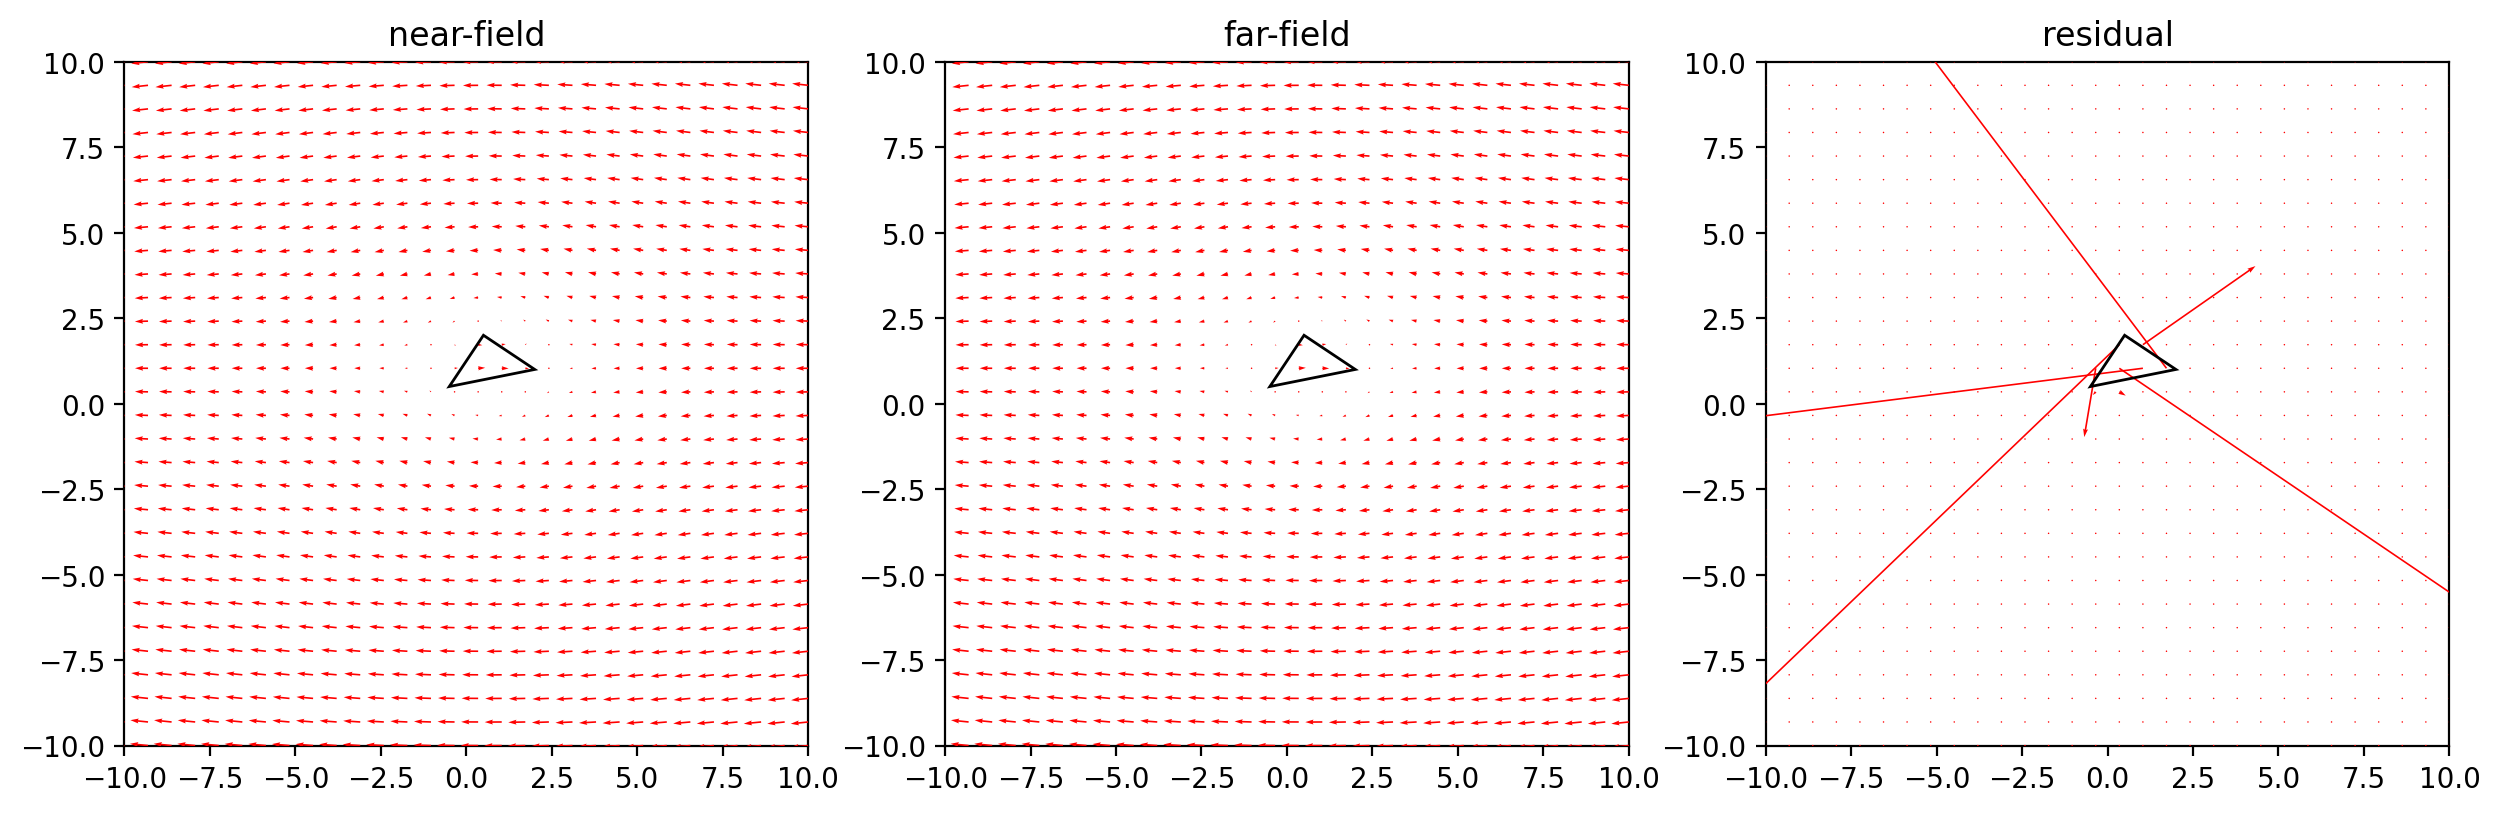

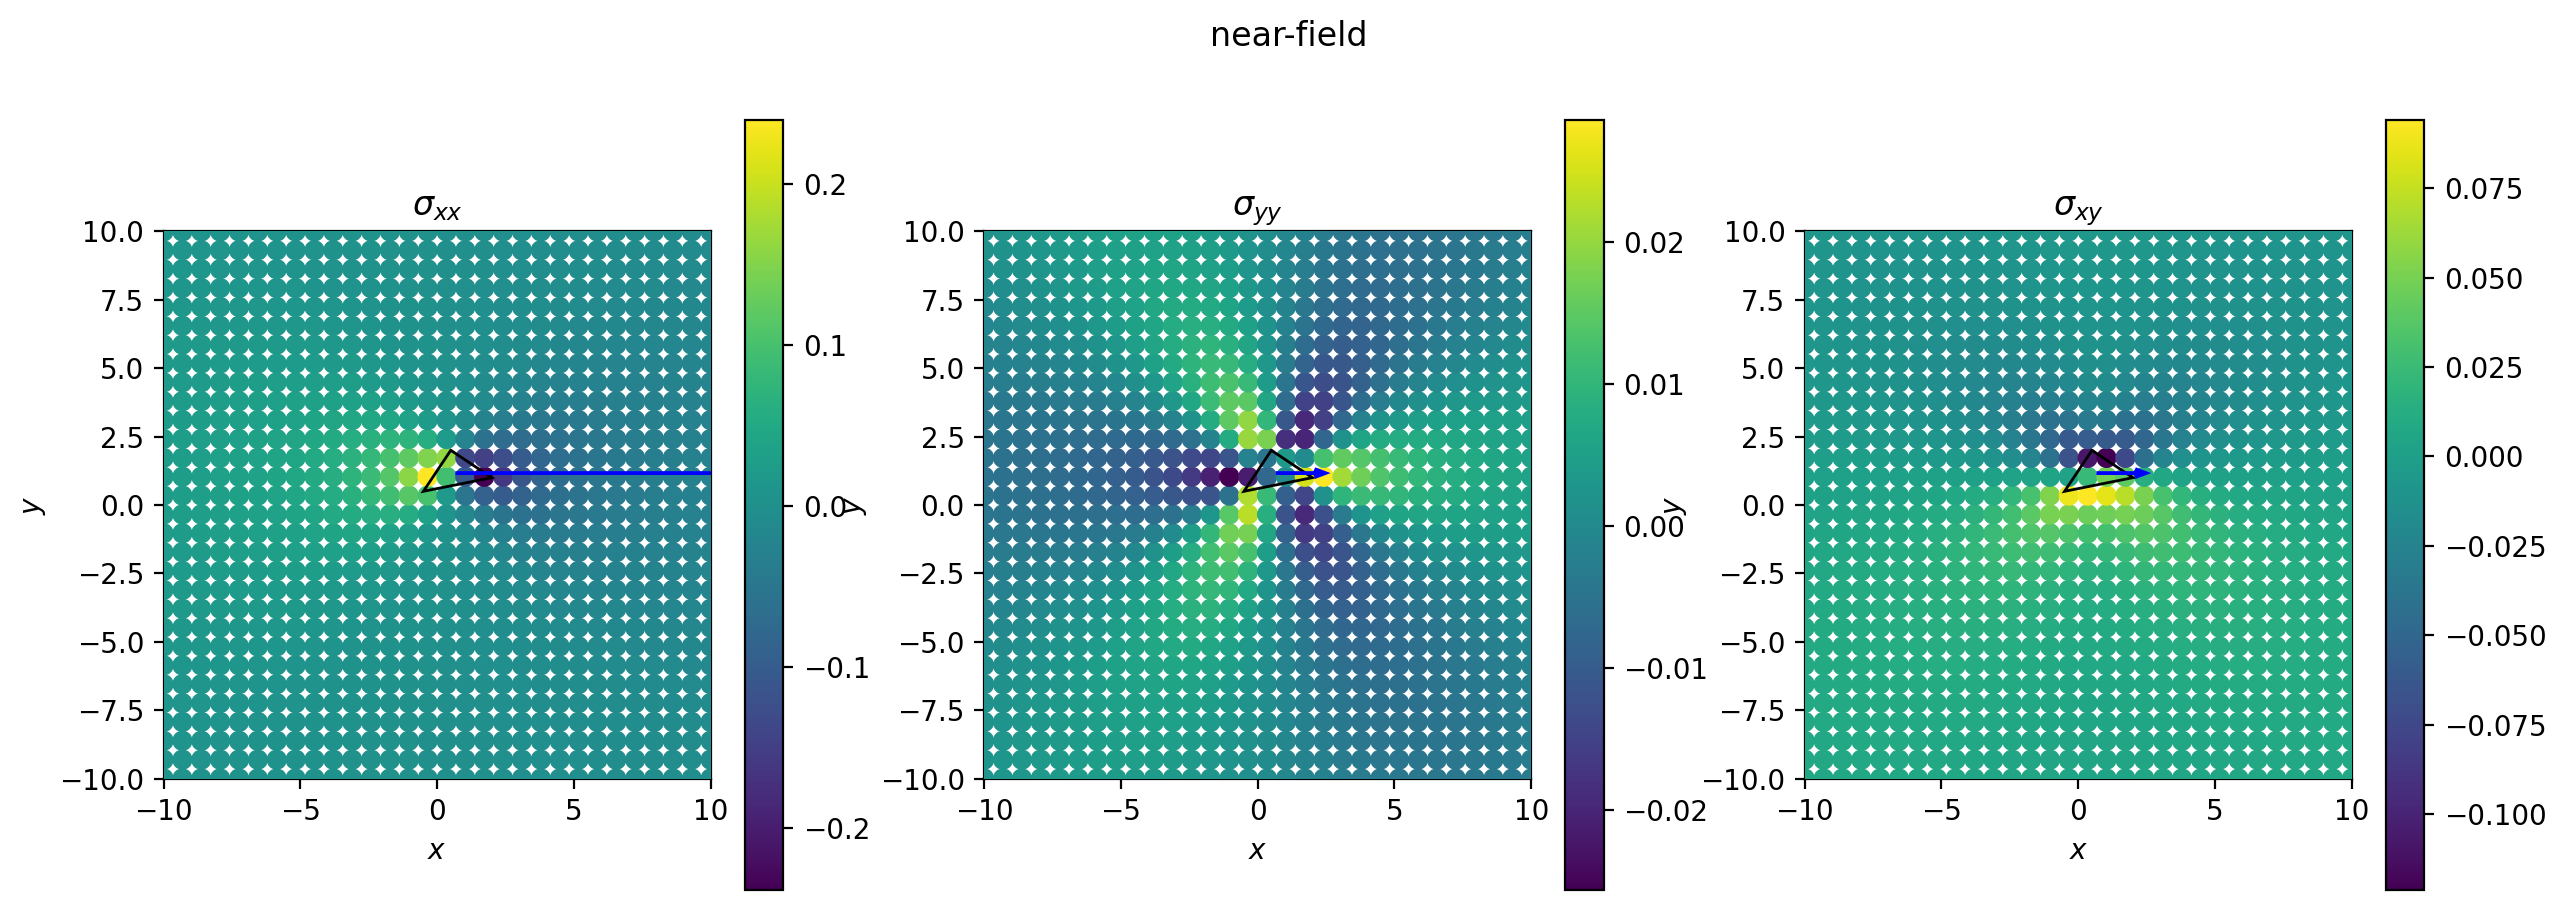

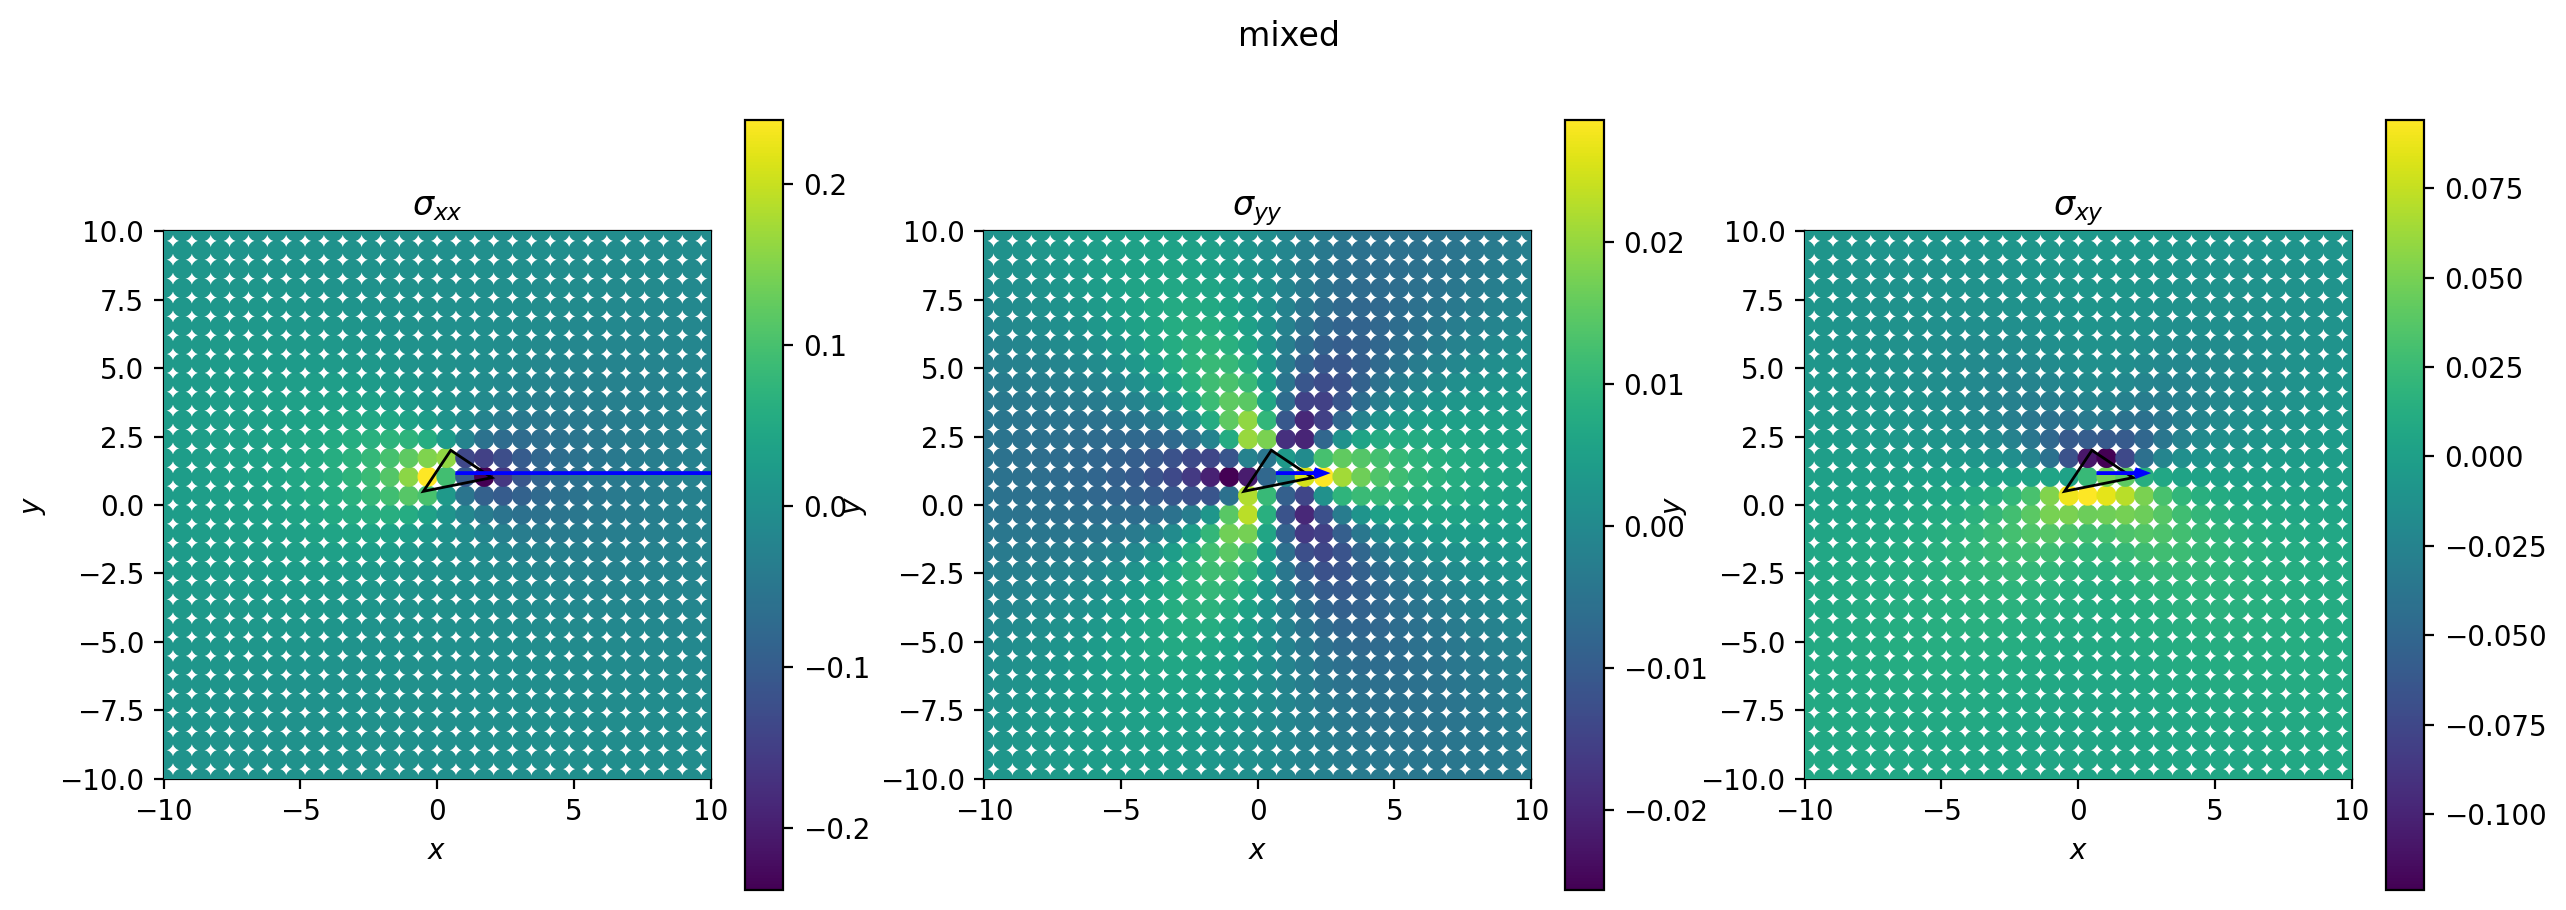

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_31416/1178905360.py:147: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(sxx_near - sxx)),
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_31416/1178905360.py:148: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(syy_near - syy)),
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_31416/1178905360.py:149: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(sxy_near - sxy)),


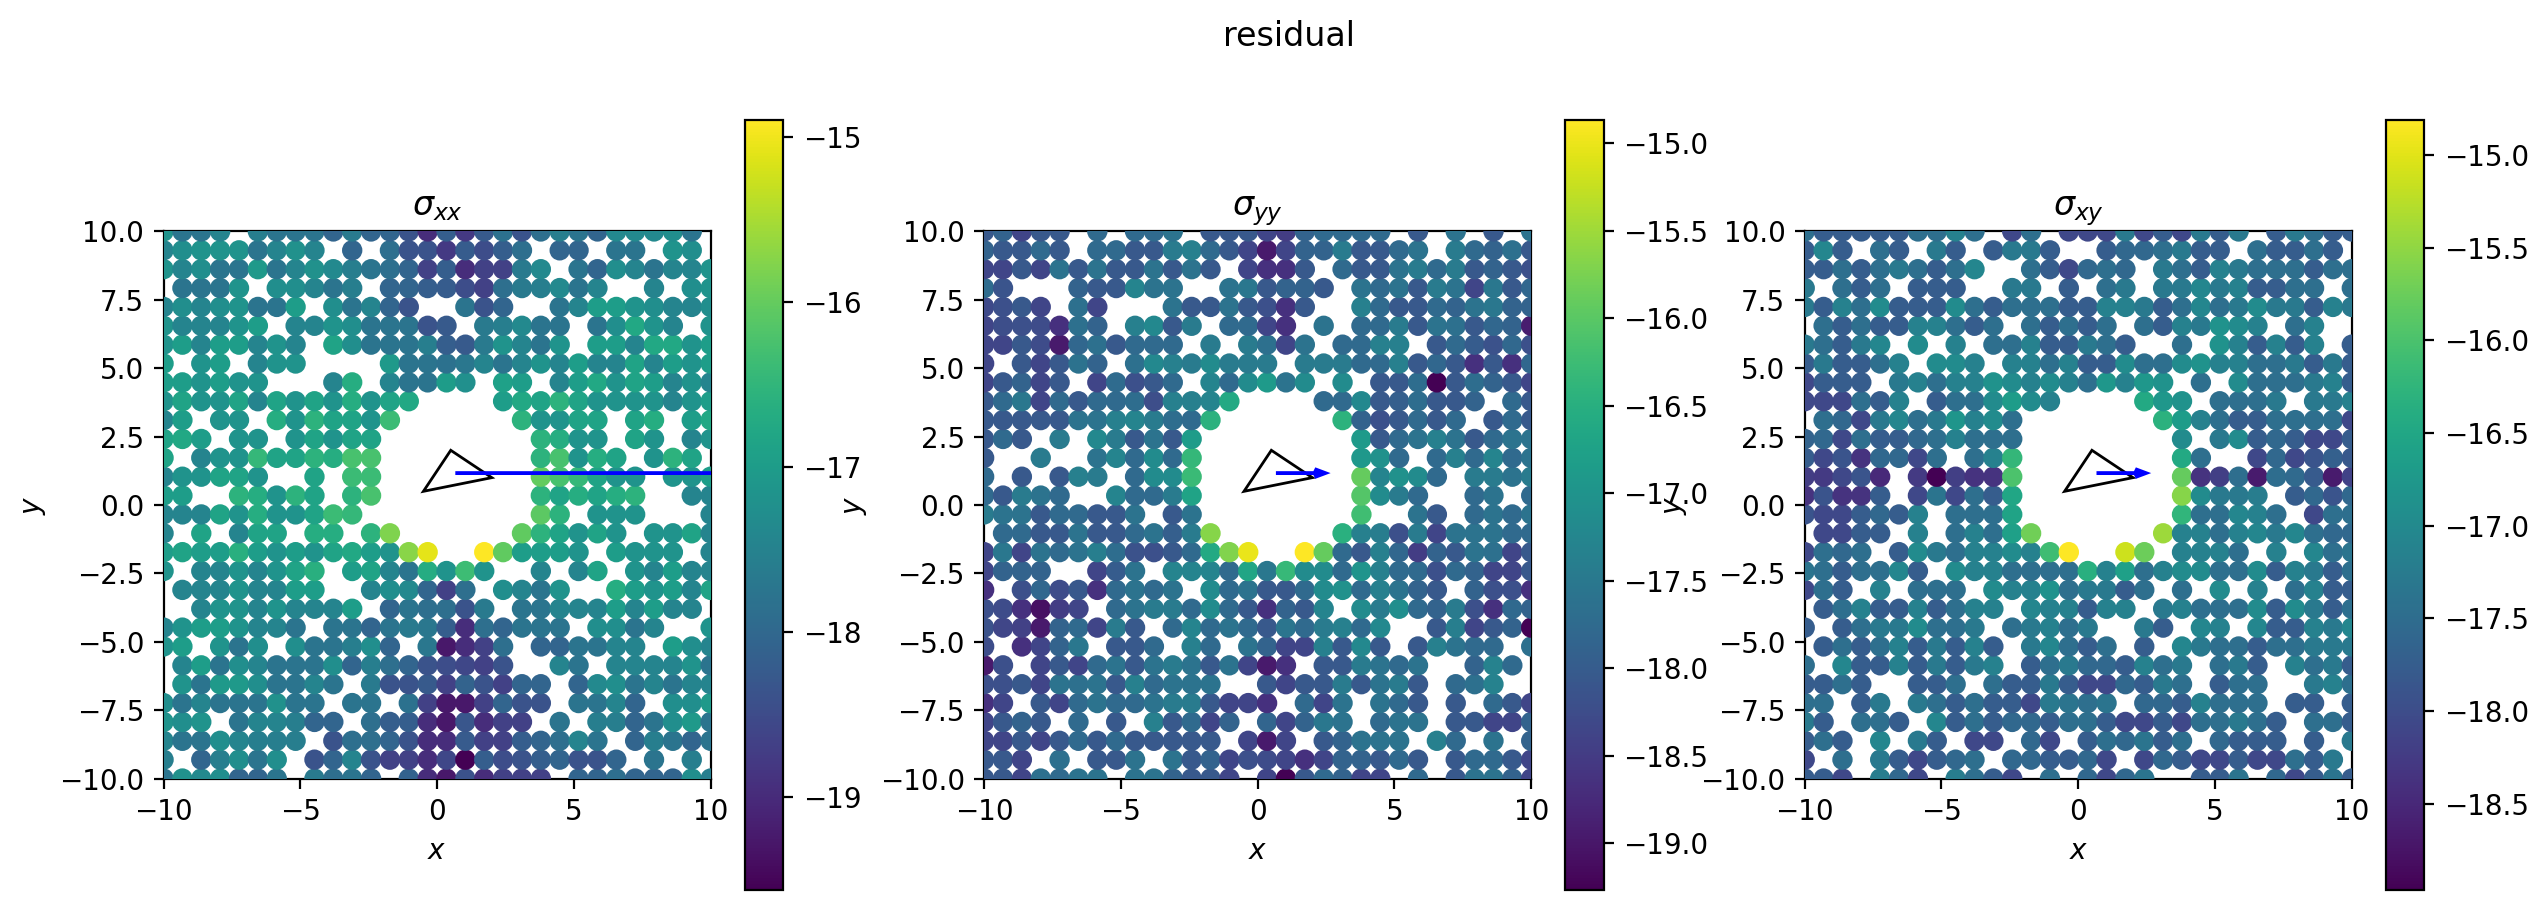

In [6]:
MARKERSIZE = 40


def plot_triangle(vertices):
    plt.fill(vertices[:, 0], vertices[:, 1], color="pink")
    plt.text(
        vertices[0, 0],
        vertices[0, 1],
        "0",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[1, 0],
        vertices[1, 1],
        "1",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[2, 0],
        vertices[2, 1],
        "2",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.gca().set_aspect("equal", adjustable="box")


def plot_triangle_outline(vertices):
    plt.fill(vertices[:, 0], vertices[:, 1], color="None", edgecolor="k", zorder=50)
    plt.gca().set_aspect("equal", adjustable="box")


def plot_common():
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])


def plot_stresses(sxx, syy, sxy, title_string):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(x_obs, y_obs, s=MARKERSIZE, c=sxx, zorder=20)
    plt.colorbar()
    plot_triangle_outline(triangle)
    plot_common()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.quiver(
        np.mean(triangle[:, 0]),
        np.mean(triangle[:, 1]),
        fx,
        fy,
        scale=1.0,
        zorder=100,
        color="blue",
        width=0.007,
        headwidth=3.0,
        headlength=4.0,
    )
    plt.title("$\sigma_{xx}$")

    plt.subplot(1, 3, 2)
    plt.scatter(x_obs, y_obs, s=MARKERSIZE, c=syy, zorder=20)
    plt.colorbar()
    plot_triangle_outline(triangle)
    plot_common()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.quiver(
        np.mean(triangle[:, 0]),
        np.mean(triangle[:, 1]),
        fx,
        fy,
        scale=10.0,
        zorder=100,
        color="blue",
        width=0.007,
        headwidth=3.0,
        headlength=4.0,
    )
    plt.title("$\sigma_{yy}$")

    plt.subplot(1, 3, 3)
    plt.scatter(x_obs, y_obs, s=MARKERSIZE, c=sxy, zorder=20)
    plt.colorbar()
    plot_triangle_outline(triangle)
    plot_common()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.quiver(
        np.mean(triangle[:, 0]),
        np.mean(triangle[:, 1]),
        fx,
        fy,
        scale=10.0,
        zorder=100,
        color="blue",
        width=0.007,
        headwidth=3.0,
        headlength=4.0,
    )
    plt.title("$\sigma_{xy}$")
    plt.suptitle(title_string)
    plt.show()


# Plot displacements
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.quiver(x_obs, y_obs, ux_near, uy_near, color="r", zorder=20)
plot_triangle_outline(triangle)
plot_common()
plt.title("near-field")

plt.subplot(1, 3, 2)
plt.quiver(x_obs, y_obs, ux_far, uy_far, color="r", zorder=20)
plot_triangle_outline(triangle)
plot_common()
plt.title("far-field")

plt.subplot(1, 3, 3)
plt.quiver(x_obs, y_obs, ux_far - ux_near, uy_far - uy_near, color="r", zorder=20)
plot_triangle_outline(triangle)
plot_common()
plt.title("residual")
plt.show()

# # Plot stressees
# plot_stresses(sxx_near, syy_near, sxy_near, "near-field")
# plot_stresses(sxx_far, syy_far, sxy_far, "far-field")
# plot_stresses(
#     np.log10(np.abs(sxx_near - sxx_far)),
#     np.log10(np.abs(syy_near - syy_far)),
#     np.log10(np.abs(sxy_near - sxy_far)),
#     "residual",
# )
# plt.show()

# Plot stressees
plot_stresses(sxx_near, syy_near, sxy_near, "near-field")
plot_stresses(sxx, syy, sxy, "mixed")
plot_stresses(
    np.log10(np.abs(sxx_near - sxx)),
    np.log10(np.abs(syy_near - syy)),
    np.log10(np.abs(sxy_near - sxy)),
    "residual",
)
plt.show()